# Python in the cloud
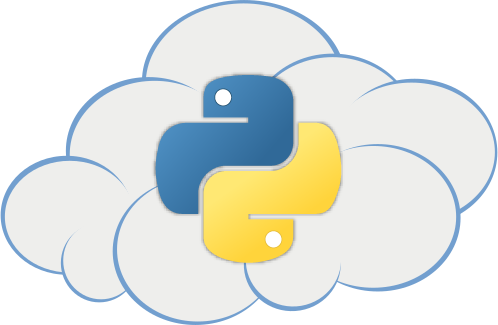
### In this notebook:
<ul>
<li><a href='#benchmark'>Benchmark your local performance</a></li>
<li><a href='#log_in'>Log in to AWS</a></li>
<li><a href='#cost'>Will this cost me?</a></li>
<li><a href='#launch'>Launch a server instance</a></li>
<li><a href='#tunneling'>SSH tunneling</a></li>
<li><a href='#new_server'>Your new server</a></li>
<li><a href='#navigating'>Navigating your server</a></li>
<li><a href='#install'>Install Jupyter</a></li>
<li><a href='#download'>Download the notebooks</a></li>
<li><a href='#start_jupyter'>Start Jupyter on the server</a></li>
<li><a href='#use_server'>Use your server</a></li>
<li><a href='#stop_server'>Stop your server to save money</a></li>
</ul>

In this notebook we'll set up a Jupyter notebooks environment in the Amazon Web Services (AWS) cloud. AWS is one of a number of powerful cloud computing platforms. Others including Google and Microsoft have competing platforms but at this time AWS is recognised as the leader.

<a id='benchmark'></a>
## Benchmark your local performance
Depending on the speed of your connection, you may have already noticed that reading data from the web service can take some time.

So far you've been running Python in Jupyter on your own laptop. That means when you work on data from a web service you must first wait for it to download to your laptop. Also the speed and capacity of processing is limited by the speed and capacity of your laptop.

Let's time the `csv_read` command to see how long it takes. We can do that by noting the time just before the read and again just after, and subtracting one from the other. We do that with the `datetime` library. 

In [ ]:
import pandas
import datetime as dt

wfs_query = 'https://citydata.be.unsw.edu.au/geoserver/wfs?srsName=EPSG%3A4326&typename=geonode%3AInsideAirbnb_44_2015_17&outputFormat=csv&version=1.0.0&service=WFS&request=GetFeature'

maxFeatures_param = '&maxFeatures=10'
PropertyName_param = '&PropertyName=City,ScrapeDate,PropertyID,HostID,Latitude,Longitude,Price'
cql_filter_param = "&cql_filter=City='Sydney'+AND+ScrapeDate='2017-04-03T00:00:00'"

url = wfs_query + PropertyName_param + cql_filter_param #  + maxFeatures_param

before = dt.datetime.now()
listings = pandas.read_csv(url)
after = dt.datetime.now()
print('Read took:', after - before)

How long did it take? If you're on a fast connection and it only took a second or two, try using the `IN` operator to add more cities to your `cql_filter_param` just to get a benchmark for a slower transfer.

Here is the list of cities you found earlier:
```
['San Francisco', 'Sydney', 'Toronto', 'Vancouver', 'Venice',
       'Vienna', 'Washington, D.C.', 'Amsterdam', 'Antwerp', 'Austin',
       'Athens', 'Barcelona', 'Boston', 'Berlin', 'Brussels', 'Chicago',
       'London', 'Los Angeles', 'Madrid', 'Melbourne', 'Montreal',
       'New Orleans', 'New York City', 'Oakland', 'Paris', 'Portland',
       'Seattle', 'Trentino', 'Copenhagen', 'Dublin', 'Edinburgh',
       'Geneva', 'Hong Kong', 'Mallorca', 'Nashville', 'Quebec City',
       'San Diego', 'Victoria', 'Rome']
       ```
You'll also need to change the `ScrapeDate` to be anything in 2017, as those other cities may have been scraped on different date from the Sydney data. This can be accomplished with the `dateFormat` function as documented [here](http://docs.geoserver.org/stable/en/user/filter/function_reference.html#filter-function-reference).

In [ ]:
cql_filter_param = "&cql_filter=City+IN+('Sydney','Melbourne','London')+AND+dateFormat('y',ScrapeDate)='2017'"
# cql_filter_param = "&cql_filter=City+IN+('Sydney','Melbourne','London')"

url = wfs_query + PropertyName_param + cql_filter_param #  + maxFeatures_param

before = dt.datetime.now()
listings = pandas.read_csv(url)
after = dt.datetime.now()
print('Read took:', after - before)


In [ ]:
print(listings.shape)
print(listings.City.unique())
print(listings.ScrapeDate.unique())



<a id='log_in'></a>
## Log in to AWS
OK now that we have a benchmark for using Jupyter locally, let's go ahead and set up Jupyter on AWS.

You may find it easier to refer to a print out of these instructions.

These instructions assume you already have an AWS account. If not, sign up now. UNSW Sydney students should sign up via AWS Educate at [this link](https://www.awseducate.com/Application?zToken=5a6843fe788f68d0d0cda471817fe583&appType=Student&inst=University%20of%20New%20South%20Wales). You'll need to wait till it is approved. This typically takes a few hours.

Click the yellow button at [aws.amazon.com](https://aws.amazon.com/) to sign in to the AWS console.

You should see a console home page something like this:

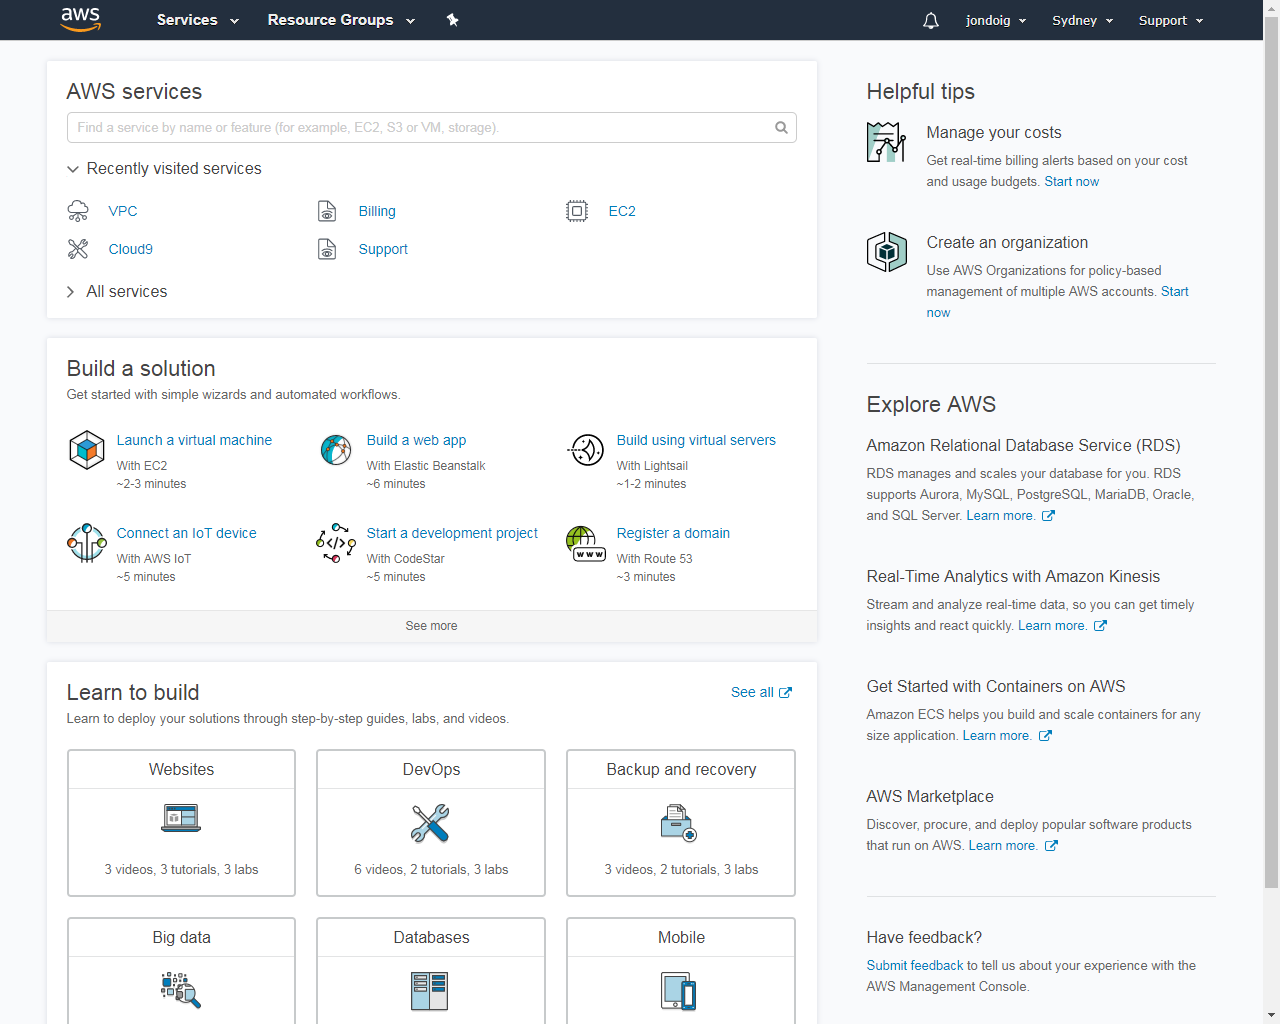

AWS has a **lot** of services to explore. When you click the services link in the top menu bar:
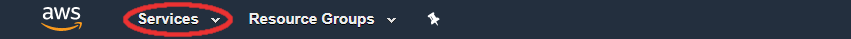

...be prepared for a wall of jargon! These services cover everything from vanilla computing databases, to machine learning, streaming image analysis and natural language processing.

<a id='cost'></a>
## Will this cost me?
Be aware that some services cost money, but you would have received a credit when you created your account through AWS Educate. Additionally some services are "free tier" meaning they're free for the first twelve months. If you signed up for a starter account, your access will be limited to free tier services.

If you have a full AWS account and you're interested in using AWS beyond the scope of this course, you might want to check the [AWS Cost calculator](https://calculator.s3.amazonaws.com/index.html) where you can explore the costs of various service options. Note you can reduce the costs of some services through billing options such as paying for a year upfront:

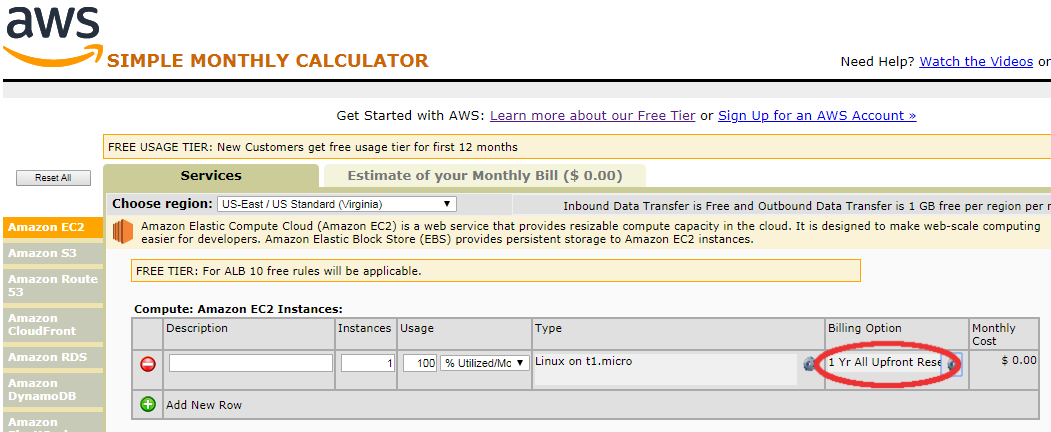

You can also check for any costs you've incurred through the Billing link in the left menu of the AWS Services drop-down page:

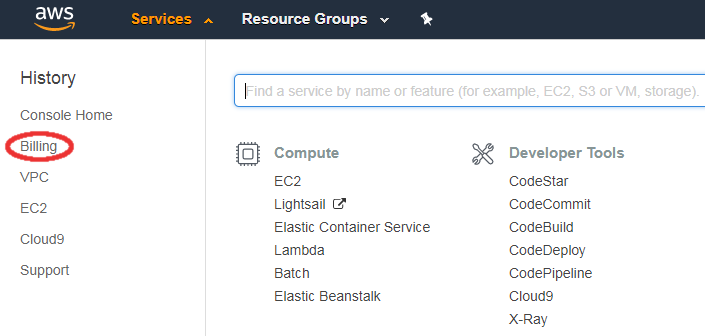

<a id='launch'></a>
## Launch a server instance
Today we'll just be using one service: EC2 (which stands for "Elastic Compute Cloud"). You'll use this to launch a server to run Jupyter in the cloud:

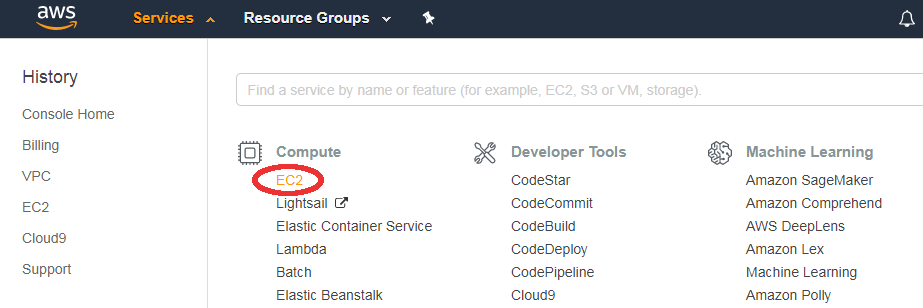

Click on EC2, then press the blue **Launch Instance** button to start the launch wizard.

Next choose an Amazon Machine Image (AMI). This is like a frozen server. You can use it as a template, and even create your own. Select **Deep Learning AMI (Ubuntu) Version 6.0**. This uses the popular open source Ubuntu operating system, a flavour of Unix:

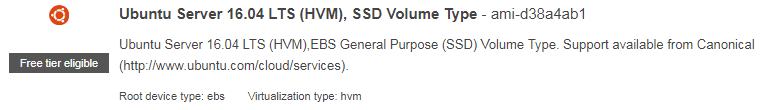

Next choose an instance type. The default is 't2.micro'. This has just one CPU and a GB of RAM, but will be sufficient for our purpose.

**Note**: although 't2.micro' says it is free tier eligible, in fact it isn't with the Deep Learning AMI. In any case, both t2.micro and t2.xlarge will be covered by the credits you received on signup.

Press **Next: Configure Instance Details**.

We'll accept all the defaults, but note a couple of interesting options here:  
* Auto Scaling Group: You can launch your instance(s) into an Auto Scaling Group and set up policies to automatically scale the number of instances in the group.
* Purchasing option: You have the option to request Spot Instances and specify the maximum price you are willing to pay per instance hour. If you bid higher than the current Spot Price, your Spot Instance is launched and will be charged at the current Spot Price. Spot Prices often are significantly lower than On-Demand prices, so using Spot Instances for flexible, interruption-tolerant applications can lower your instance costs by up to 90%

Press **Next: Add Storage**.

Note that the server already has a 75 GB disk, of which 50 GB is used by software. That leaves 25 GB which is plenty unless you want to actually store very big datasets. You can always add more storage later if you need it.

Press **Next: Add Tags**

Tags are metadata to help keep track of your AWS resources.

Add a Name tag:  
* Click **Add Tag**
* Enter "Name" under Key and a name for the server (e.g. "Jupyter notebooks server") under Value.

Add another tag for Owner, with your name as the Value.

Press **Next: Configure Security Group**.

As it says on the page, a security group is a set of firewall rules that control the traffic for your instance. On this page, you can add rules to allow specific traffic to reach your instance.

The default rule allows secure shell (SSH) access, which is what you'll need to access Jupyter notebooks on the server from your laptop:

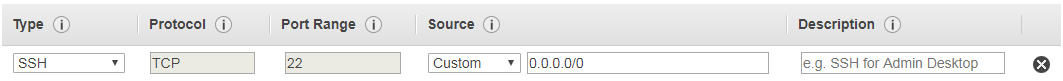

However the default rule allows this access by anyone. The entry 0.0.0.0/0 under **Source** is an IP address (0.0.0.0) followed by "/0". The 0 means enforce 0 bits of the address, which actually means "ignore all of this IP address", hence it's open to anyone.

Replace it with your own IP address, which you can find by Googling [what's my IP](https://google.com/search?q=what%27s+my+IP), followed by /32, which means enforce all 32 bits (4 bytes) of the address: restrict it just to you, not the world, not anyone else in your subnet, just you.

For example, my IP address is 211.30.23.60, so I enter 211.30.23.60/32.

Enter something meaningful under **Description**, such as "SSH from my laptop".

Click **Review and Launch**.

Check that the options are what you wanted, and click **Launch**.

You will be prompted to "select an existing key pair or create a new key pair".

A key pair consists of a public key that AWS stores, and a private key file that you store. Together, they allow you to securely access your instance via SSH.

In the dropdown, select "Create a new key pair". Give the key a name, such as "aws". Click **Download Key Pair** and save the `aws.pem` file on your laptop.

Now do it! Click **Launch Instances**!

If all goes well you'll see a launch status screen that says:

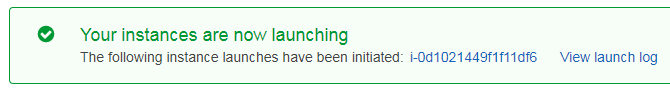

Click **View Instances**.

On the AWS Instances page, select the instance you just launched (with Name "Jupyter notebooks server").

The lower panel will show the details of this instance including the Public DNS (IPv4), which you will need to connect from your laptop. Hover this field then click the icon to copy it to your clipboard:

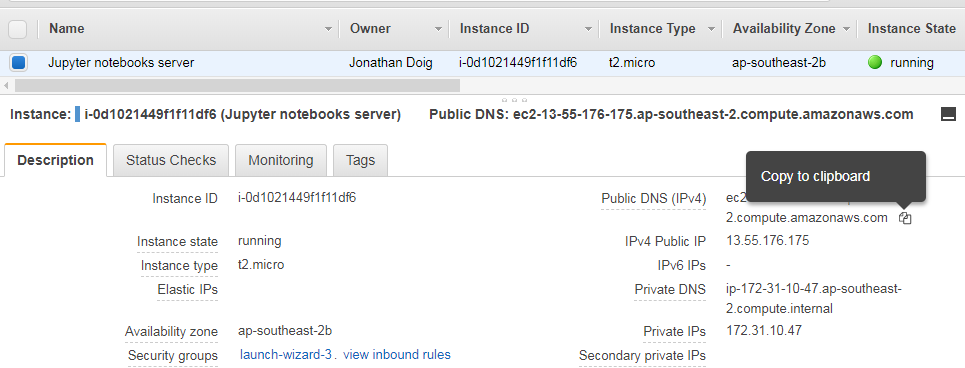

<a id='tunneling'></a>
## SSH tunneling

You will use a technique called 'SSH tunnelling' (or 'SSH port forwarding') to connect to your server. That allows you to use your local browser to open Jupyter from the server as if it were running on your local machine. This is accomplished by sending the browser traffic through your SSH connection, hence 'tunneling'.

By default Jupyter uses port 8888, but we suggest to use port 9999 on the server so it will not conflict with your local Jupyter installation on port 8888 and you can run them both at the same time.

How you do this depends whether you have a Windows or Mac laptop.

### Mac: run your built-in SSH command
If you have a Mac, congratulations! Your macOS (formerly OS X) operating system is a flavour of Unix. This means you can run `ssh` from the command line to establish a tunnel to your server:

`ssh -i aws.pem -o ServerAliveInterval=120 -L 9999:localhost:9999 ubuntu@`*HOSTNAME*

where *HOSTNAME* is the Public DNS you copied from your AWS Instances page.

[Skip to your next step](#new_server).

### Windows: set up an SSH tunnel with PuTTY

Windows has no ssh (secure shell) command built-in. You'll need to download software for that.

The standard software is a functional but ugly tool called PuTTY. (So ugly it seems there's a [cottage industry](https://google.com/search?q=PuTTY+themes) around re-theming it).

Also PuTTY can't use the pem private key file you downloaded directly. You'll  first need to convert it to a ppk file. But PuTTY provides a tool for that.

Click the **Windows Start** button and search for "putty". You should see at least two entries: PuTTY and PuTTYgen. Click to run **PuTTYgen**. If PuTTY is not installed you can download it from [here](https://www.putty.org).

From the top menu of PuTTYgen, click **Conversions > Import key**. Select the pem file you downloaded and click **Open**. That will show the encrypted key.

Click **Save private key**. You will prompted with a warning: click **Yes**.

Give the file a name, such as "aws.ppk" and click **Save**.

Close PuTTYgen.

Click **Windows Start** and search for "putty" again. This time run PuTTY itself.

Under **Host Name or IP address**, paste the Public DNS of your server that you just copied from the AWS Instances page.

Under **Saved Sessions**, type something descriptive for your server, such as "AWS Jupyter":

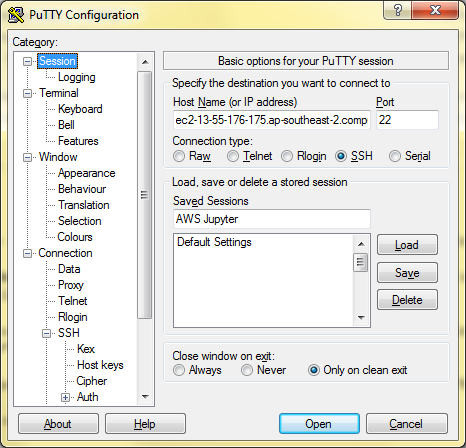

Now click the **+** on the left beside **SSH** to expand this entry, then click **Auth** to load your private security key.

Click **Browse**, select the ppk file you saved from PuTTYgen and click **Open**.

Now click **Tunnels** on the left to specify the start and end points for your tunnel:

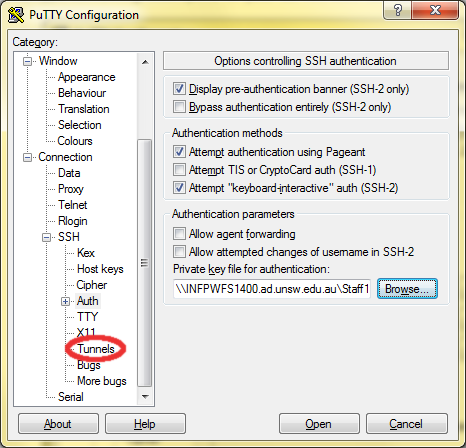

Beside **Source port** enter **9999**

Beside **Destination** enter **127.0.0.1:9999**

Click **Add**.

Your PuTTY should look like this:
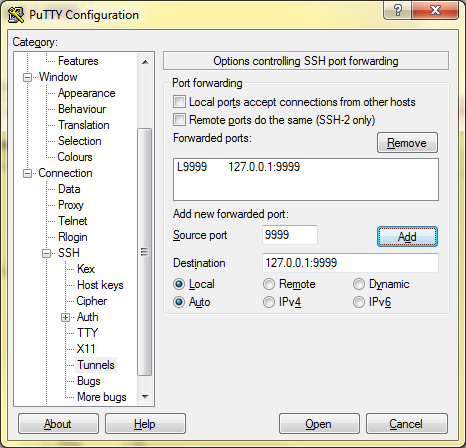

Click Connections on the left and enter `120` beside **Seconds between keepalives**. This prevents the connection from dying by default if you leave it idle for a few minutes.
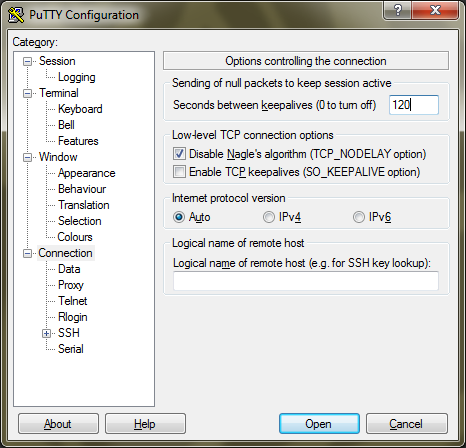

Scroll the left menu back to **Session** at the top. Click **Save** to save this session (as "AWS Jupyter").

Now click **Open** to connect to your server.

You'll see a PuTTY security alert:

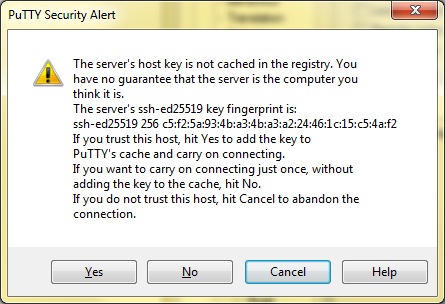

Click **Yes** to accept the key from your server and save it in the cache.

<a id='new_server'></a>
## Your new server
If all goes well, a terminal window will open: 

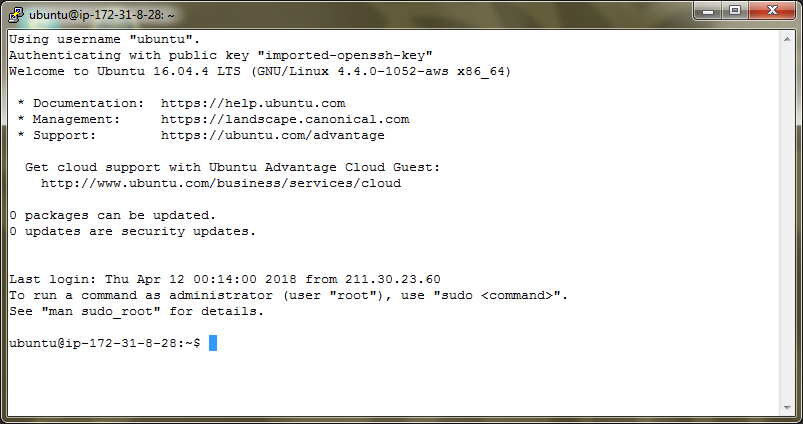

***Welcome to your brand new server!*** 

<a id='install'></a>
## Install Jupyter

We'll go to the same web page we used to install Jupyter notebook locally: [Installing Jupyter Notebook](http://jupyter.readthedocs.io/en/latest/install.html)

But this time we'll follow the *Alternative for experienced Python users*: **Installing Jupyter with pip.**

As it says there, Jupyter installation requires Python 3.3 or greater.

Check your version of Python 3:  
`python3 -V`

As you'll see it's a later version than 3.3 so we're good to install jupyter.

But first, you'll need **pip**, a package management system used to install and manage software packages written in Python. You can install it with Ubuntu's Advanced Packaging Tool (APT).

First, update installed packages and their dependencies:  
`sudo apt-get update`

The `sudo` command means "do this as superuser"; it's the Unix equivalent to running a command as administrator.

Now install pip:  
`sudo apt-get -y install python3-pip`

Then you're ready to use pip to install Jupyter:  
`sudo pip3 install jupyter`

To confirm the install, check the jupyter version:  
`jupyter --version`

## Save your machine image

Now that you've installed Jupyter, let's save the state of the server in your own AMI. That way if you need another Jupyter server you can launch it from this AMI without having to install the software again.

In the AWS Instances screen, select your Jupyter server and click Actions > Image > Create Image:

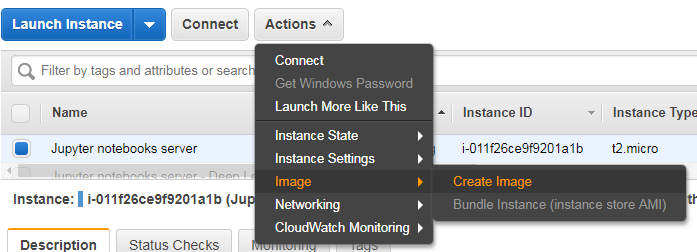

In the dialog that appears, enter an image name. It's a good idea to include the version numbers, e.g.:  
"Jupyter 4.4 on Ubuntu 16.04"

Click **Create Image**.

Your server will shut down to create the image, which will close your connection to the server. On Windows you'll get this message from PuTTY:

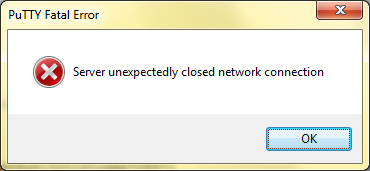

The AWS Instances page will show when your server has restarted. Then you can reconnect as above with PuTTY on Windows or SSH on Mac.

The image you created is now available under **Images > AMIs** in the left hand menu of the AWS Console.

To use it next time you launch an instance, select **My AMIs** on the left hand side of *Step 1: Choose an Amazon Machine Image (AMI)*:

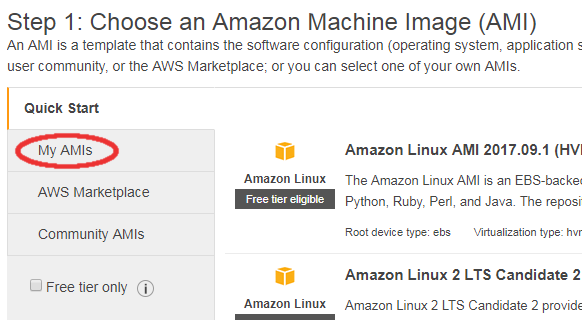

<a id='download'></a>
## Download the notebooks

At City Futures Research Centre we store our notebooks on GitHub, a popular web-based hosting service for software version control.

Use the `git` command to download the notebooks from our code repository on GitHub into your home directory:

`git clone https://github.com/UNSW-CFRC/Programmable-Cities-Block-1-Jupyter-notebooks`


<a id='navigating'></a>
## Navigating your server

Your terminal window is a command line interface into your server. You can run any standard (Ubuntu flavoured) Unix command there. By default, you are located in your home directory.

Here are some useful Unix commands to find your way around. Try them now to check what your just downloaded:  
* `pwd` - print working directory (i.e. show your current directory location)
* `ls` - list files in the current directory
* `cd` - change directory (to your home directory by default)

These and a handful of other basic commands are explained with examples [here](https://en.wikibooks.org/wiki/Guide_to_Unix/Commands/File_System_Utilities).

**Tip**: when typing a file or directory name, just type the first few characters and then press the TAB key for auto-completion. This is a feature of the `bash` shell you're running when you login to your server. (Lots more about `bash` [here](http://cs.lmu.edu/~ray/notes/bash/)).

<a id='start_jupyter'></a>
## Start Jupyter on the server

To start Jupyter on the server type:  
`jupyter notebook --port=9999`

The application will output some diagnostic details and then give the URL to connect from your laptop, e.g.:
```
    Copy/paste this URL into your browser when you connect for the first time,
    to login with a token:
        http://localhost:9999/?token=b060ab578c96f3a7bd76a0fef04bfabcbbd9b484f185a9d7
```

As it says, copy and paste the URL into your browser to connect. You should see a window like this:

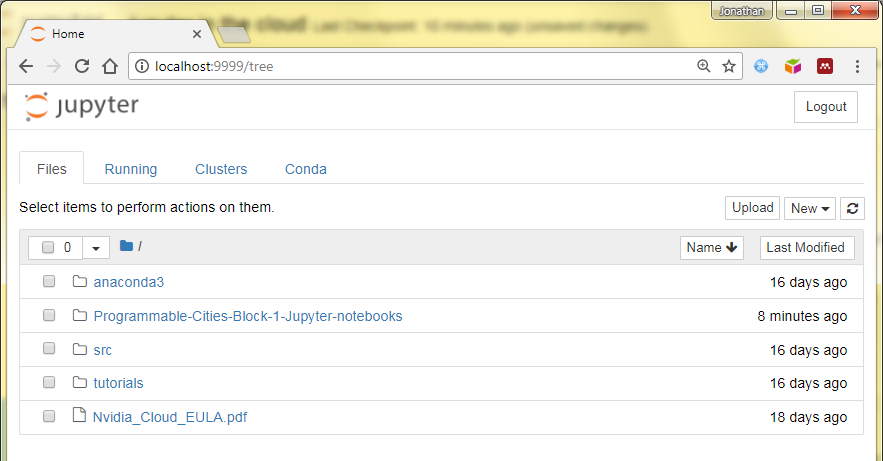

<a id='use_server'></a>
## Use your server
Great: now you're ready to start using Jupyter notebook on your new AWS server!

Open notebook **4. Interactive plotting with plotly** from your new server-based Jupyter browser window to compare the performance with the benchmark you set earlier on your local machine.

<a id='stop_server'></a>
## Stop your server to save money
To avoid chewing through your AWS credit, stop the server and restart it when you need it.

On the AWS EC2 Instances page:  
* Select your server by clicking its box
* Click Yes to confirm

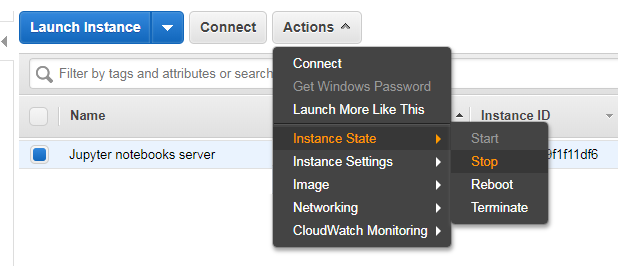

To restart it when you need it again:
* Click Actions > Instance state > Start
* Connect to your server with PuTTY (Windows) or SSH (Mac)
* <a href='#start_jupyter'>Start Jupyter on the server</a>